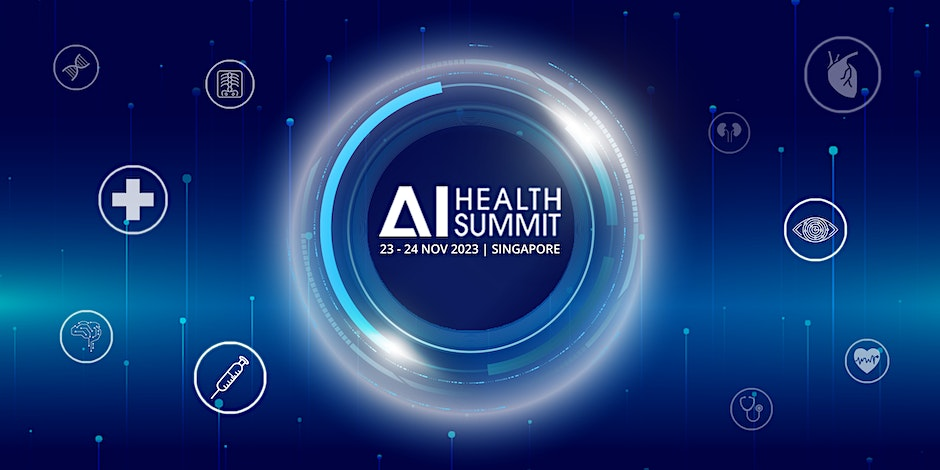

# Building an evaluation-driven Retrieval Augmented Generation (RAG) pipeline for clinician support

In this notebook, we will build and optimize a LLM assistant Chatbot to tackle different use cases in medical operations. We will learn how to call **OpenAI API** to streamline LLM-related tasks and have better control over text generation parameters. We will use **Langchain** library to construct Prompt recipes and incorporate Vector Database to help improve LLM's answer quality. <br><br>

# Install Packages Dependencies

- langchain: Main package for building LLM application
- openai: For use OpenAI LLM model as engine for application
- faiss-cpu: Facebook AI Similarity Search. Vector Database for document retrieval.
- tiktoken: Package for counting tokens consumed by LLMs. Support several LLMs including OpenAI and HuggingFace models.
- pypdf & PyMuPDF: Package for loading PDF documents.

In [ ]:
# !pip install openai llama_index PyPDF tiktoken faiss-cpu PyMUPDF jinja2 spacy

Let's also setup our working directory and download sample data files for our examples. The data_files.zip includes 3 folders:
- Example 1: patients_summary.csv file containing patients summary
- Example 2: 4 transcripts of doctors - patients consultations.
- Example 3: 10 PDF documents containing guidelines for treatment of diseases

In [ ]:
# %mkdir health_summit_workshop # Create directory
# %cd /content/health_summit_workshop # Move into the directory

In [6]:
# from google.colab import drive

# drive.mount("/content/drive")
# %cd /content/drive/My Drive/LLM/workshops/ai_summit

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/LLM/workshops/ai_summit


In [1]:
# Import basic package
import os
import pandas as pd
from typing import List, Dict, Union
from pprint import pprint

# MAIN_DIR = os.getcwd() # Set Main Working Directory
MAIN_DIR = "."

In [ ]:
# !pip3 install --upgrade gdown # Install google download package
# !gdown  # Download data files from google drive
# !unzip data_files.zip # Unzip file

# OpenAI API
- OpenAI API is one of the fastest and convenient ways which allow developers to use LLMs to build application.

- When provided with a text prompt, the API will generate a text completion with the aim of aligning with the provided pattern. You can guide its behavior by presenting a few illustrative examples of your desired output.

- To use OpenAI models, we need a working API-Key. You can register for your own key at https://openai.com/blog/openai-api. On your first registration, you will be given some free credits to try out the API.

In [2]:
import nest_asyncio

nest_asyncio.apply()

In [3]:
# # Enter OpenAI Key

# import openai
# from getpass import getpass

# openai.api_key = getpass(prompt='Please enter your OPENAI API KEY: ') # For secure password input
# os.environ["OPENAI_API_KEY"] = openai.api_key # Set environment variable OPENAI_API_KEY

import nest_asyncio

nest_asyncio.apply()

import json
import openai
import os
with open(os.path.join("..", "auth", "api_keys.json"), "r") as f:
    api_keys = json.load(f)
    
openai.api_keys = api_keys["OPENAI_API_KEY"]
os.environ["OPENAI_API_KEY"] = api_keys["OPENAI_API_KEY"]

#  Retrieval Augmented Generation Question Answering with LlamaIndex

One fundamental weakness of LLMs is that their knowledge is limited by the data used to train the models. Hence LLMs do not have access to information after knowledge cutoff as well as knowledge outside of its training data (e.g. specific domain data)

Currently, there are 2 main ways to address this problem:
1. Fine-Tune the LLM with latest data
2. In-Context Learning: Provide the LLM with the updated information inside the prompt.

Fine-Tuning is effective but is also very costly in terms of computation and data preparation. In addition, it doesn't solve the problem of un-updated knowledge base, as models fine-tuned today may be outdated a year later and need to be fine-tuned again.

In-Context Learning hence is an attractive solution to allows LLMs to have access to latest data at the point of running. In addition, it has been shown that models provided with contexts tend to have their answers grounded and less likely to hallucinate.

In this exercise, we will build a system to retrieval relevant data from a vector database and provide the data to the LLMs as context.

Before that, let's test a basic LLM model on a medical question specific to a disease and patient condition.

In [4]:
from llama_index import SimpleDirectoryReader
from llama_index import ServiceContext
from llama_index.vector_stores import SimpleVectorStore
from llama_index.storage import StorageContext
from llama_index.embeddings import OpenAIEmbedding
from llama_index import VectorStoreIndex

## Create Vector database

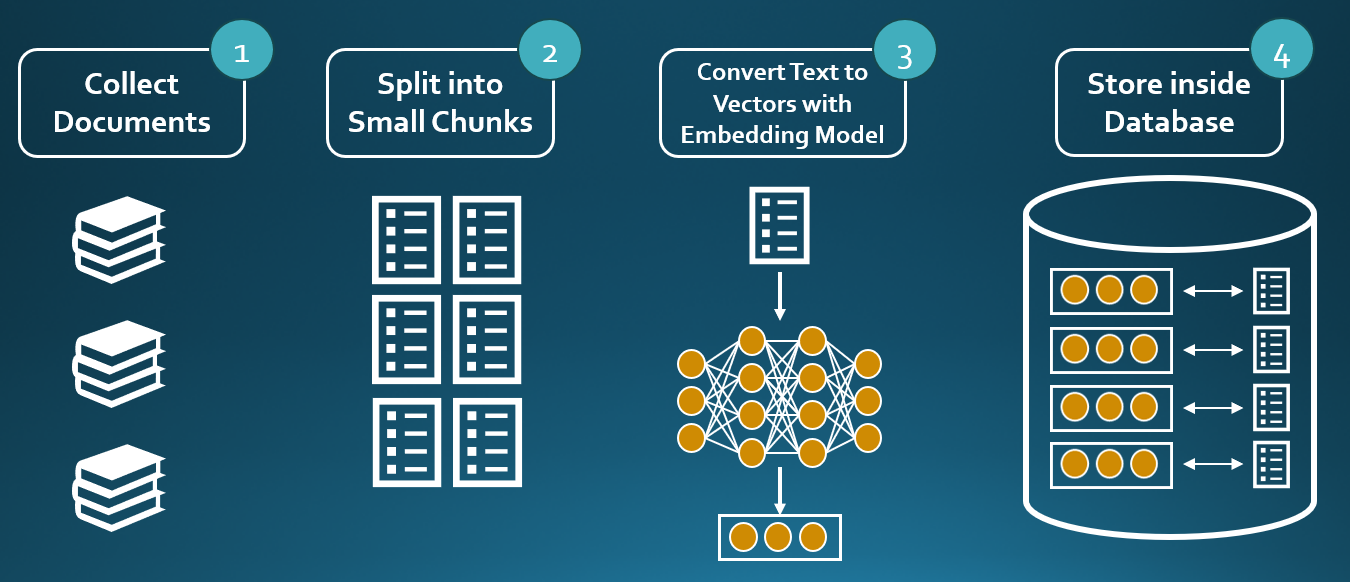

- We will create a vector index database using Facebook AI Similarity Search Database. Facebook AI Similarity Search (Faiss) is a library for efficient similarity search and clustering of dense vectors.

- We use OpenAIEmbeddings model to convert the texts into the vector representations which will be used for similarity search.
- Typically, the loaded documents are further split into smaller text chunks with some overlapping window (to keep some contextual information between chunks). The size and overlapping window of the text chunk is a parameter for tuning.

In [5]:
DATA_DIR = os.path.join(MAIN_DIR, "data", "documents")
DB_DIR = os.path.join(MAIN_DIR, "data", "database")
documents = SimpleDirectoryReader(DATA_DIR).load_data()

print("Number of pages collected:", len(documents))

Number of pages collected: 77


In [6]:
CHUNK_SIZE = 128
CHUNK_OVERLAP = 20

db_service_context = ServiceContext.from_defaults(
    chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP, embed_model=OpenAIEmbedding()
)
storage_context = StorageContext.from_defaults(
    vector_store=SimpleVectorStore()
)
vector_index = VectorStoreIndex.from_documents(
    documents, storage_context = storage_context, service_context=db_service_context
)

If you have already built a database, you can simply load it by providing the directory to the database folder.

In [7]:
vector_index.set_index_id("workshop")
vector_index.storage_context.persist(
    persist_dir = os.path.join(DB_DIR, f"{CHUNK_SIZE}_{CHUNK_OVERLAP}")
)

Then you can load Vector Index by loading the Vectorstore from persist directory

In [8]:
from llama_index import load_index_from_storage

vector_store = SimpleVectorStore.from_persist_dir(
    os.path.join(DB_DIR, f"{CHUNK_SIZE}_{CHUNK_OVERLAP}"), namespace="default"
)

storage_context = StorageContext.from_defaults(
    vector_store=vector_store,
    persist_dir=os.path.join(DB_DIR, f"{CHUNK_SIZE}_{CHUNK_OVERLAP}")
)

vector_index = load_index_from_storage(
    storage_context=storage_context, index_id="workshop"
)

## Similarity Search
Once the database is created, we can input a query and ask the database to return the most relevant documents to our query.

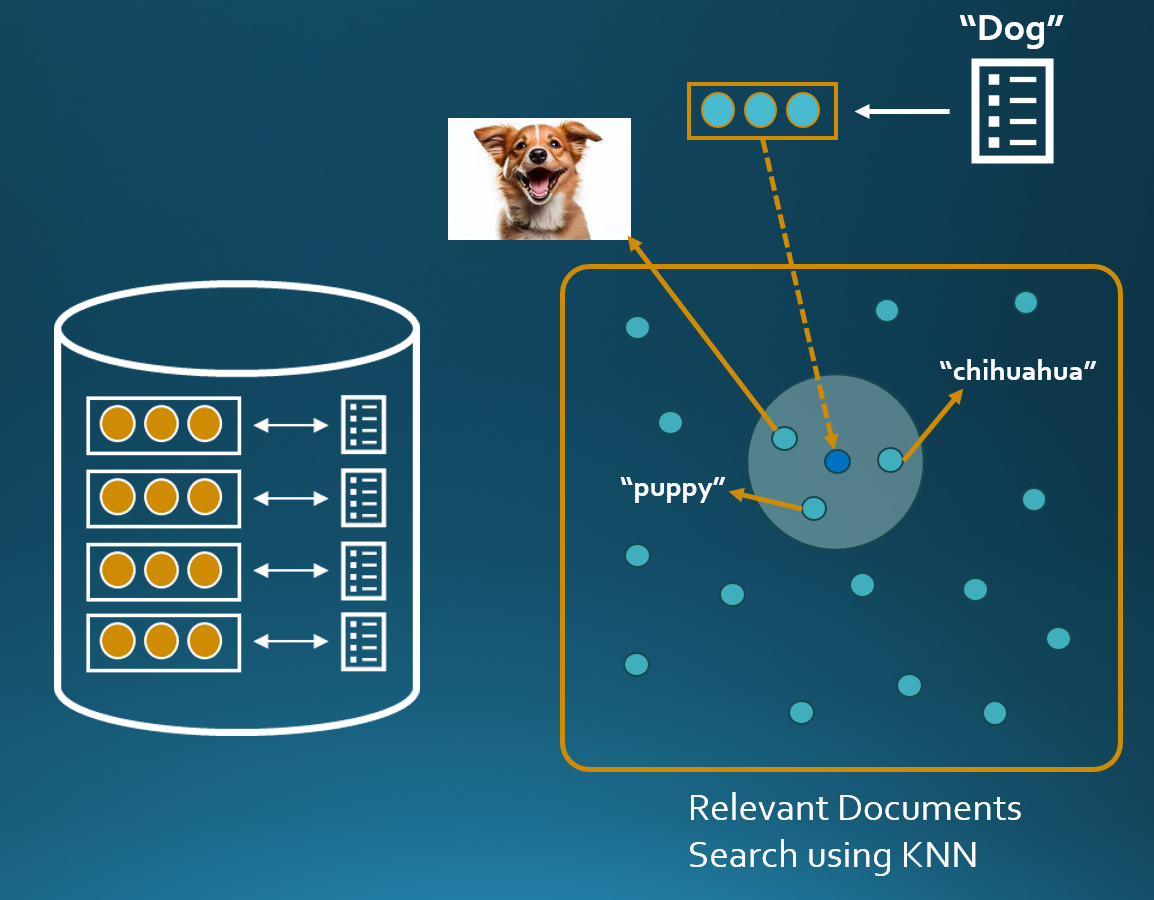


By default, the implementation of FAISS in Langchain uses Eucleadean distance (L2) as the distance measurement.

In [9]:
vector_retriever = vector_index.as_retriever(similarity_top_k = 4)

In [10]:
question_1 = (
    "What is the recommended colonoscopy screening for Polyp patients "
    "with history of family members having Colon Cancer Syndrome X?"
    ) 

relevant_nodes = vector_retriever.retrieve(question_1)
relevant_nodes

[NodeWithScore(node=TextNode(id_='50ee240e-5e7d-4504-9f38-237434fee538', embedding=None, metadata={'page_label': '10', 'file_name': 'MSTF 2017 CRC Screening.pdf', 'file_path': 'data/documents/MSTF 2017 CRC Screening.pdf', 'file_type': 'application/pdf', 'file_size': 1062131, 'creation_date': '2023-11-16', 'last_modified_date': '2023-11-15', 'last_accessed_date': '2023-11-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='279cfa4c-65cb-4589-8fa9-0783d7e88cfa', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '10', 'file_name': 'MSTF 2017 CRC Screening.pdf', 'file_path': 'data/documents/MSTF 2017 CRC Screening.pdf', 'file_type': 'application/pdf', 'file_size': 1062131, 'creation_date': '2023-1

In [12]:
for idx, node in enumerate(relevant_nodes):
    node_content = node.text
    node_metadata = node.metadata
    node_score = node.score
    print("Node {} - File: {}, Page: {} - Score = {}"
          .format(idx + 1, node_metadata["file_name"], node_metadata["page_label"], node_score))
    print(f"Content: {node_content}\n\n")

Node 1 - File: MSTF 2017 CRC Screening.pdf, Page: 10 - Score = 0.893679319043624
Content: Histories Not Associated With Polyp Syndromes
Family history Recommended screening
Lynch Syndrome See reference 34
Family Colon Cancer Syndrome X Colonoscopy every 3-5 years beginning 10 years before the age at
diagnosis of the youngest affected relative
Colorectal cancer or an advanced adenoma in two
ﬁrst-degree relatives diagnosed at any age
OR colorectal cancer or an advanced adenomain a single ﬁrst-degree relative at age <60 yearsColonoscopy every 5 years beginning 10


Node 2 - File: MSTF 2017 CRC Screening.pdf, Page: 9 - Score = 0.8834601910097452
Content: 122Persons
in families with syndrome X should undergo colonoscopy at
least every 3 to 5 years, beginning 10 years before the age at
diagnosis of the youngest affected relative.
A family history of CRC in a ﬁrst-degree relative in-
creases the risk of CRC regardless of the age at diagnosis ofTable 4. Multi-Society Task Force Ranking of Curr

## Question Answering with Vectorsearch

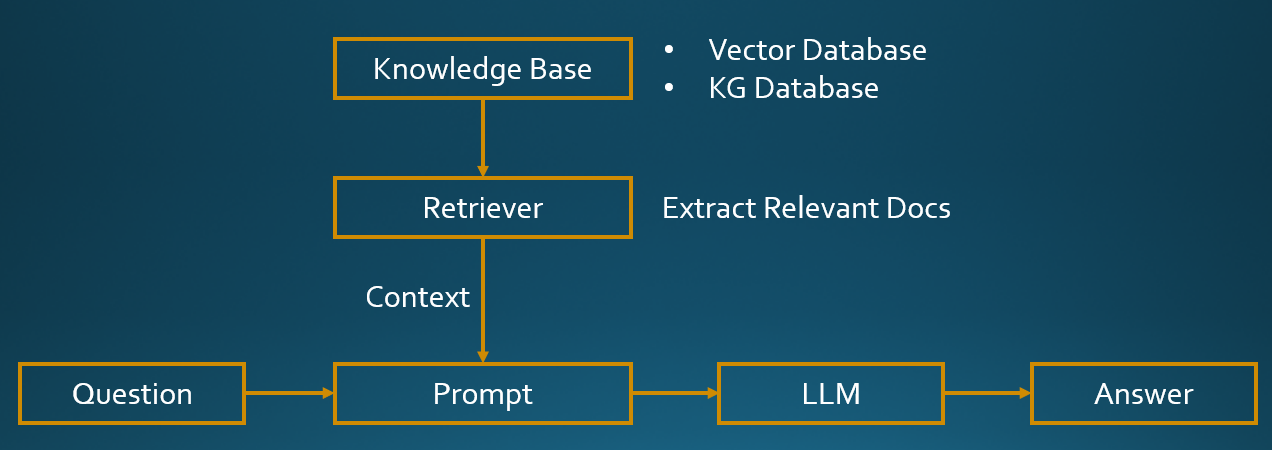

Now we will create a RetrievalQAWithSourcesChain which will integrate our QA from docs with the vector database. <br>

Under the hood, the retriever will retrieve/filter the most relevant documents from the database before stuffing it inside our context placeholder.

In [13]:
from llama_index.prompts import PromptTemplate

custom_template = (
    "You are a helpful AI Medical Assistant. Your task is to provide truthful answers "
    "for junior doctors. Strictly answer only based on the information given under CONTEXT "
    "If you don't know the answer or the answer is not inside the CONTEXT, return 'No Answer'.\n"
    "---------\n"
    "CONTEXT: {context_str}"
    "---------\n"
    "QUESTION: {query_str}"
)

CUSTOM_QA_TEMPLATE = PromptTemplate(custom_template)

In [14]:
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.llms import OpenAI
from llama_index import get_response_synthesizer

synthesizer_service_context = ServiceContext.from_defaults(
    llm=OpenAI(model="gpt-3.5-turbo-1106", temperature=0),
)

response_synthesizer = get_response_synthesizer(
    service_context=synthesizer_service_context,
    text_qa_template=CUSTOM_QA_TEMPLATE,
    response_mode="simple_summarize"
)

query_engine = RetrieverQueryEngine(
    retriever=vector_retriever,
    response_synthesizer=response_synthesizer
)

In [15]:
response = query_engine.query(question_1)
response

Response(response='Colonoscopy every 3-5 years beginning 10 years before the age at diagnosis of the youngest affected relative.', source_nodes=[NodeWithScore(node=TextNode(id_='50ee240e-5e7d-4504-9f38-237434fee538', embedding=None, metadata={'page_label': '10', 'file_name': 'MSTF 2017 CRC Screening.pdf', 'file_path': 'data/documents/MSTF 2017 CRC Screening.pdf', 'file_type': 'application/pdf', 'file_size': 1062131, 'creation_date': '2023-11-16', 'last_modified_date': '2023-11-15', 'last_accessed_date': '2023-11-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='279cfa4c-65cb-4589-8fa9-0783d7e88cfa', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '10', 'file_name': 'MSTF 2017 CRC Screening

In [16]:
pprint(f"Response:\n{response.response}")

('Response:\n'
 'Colonoscopy every 3-5 years beginning 10 years before the age at diagnosis '
 'of the youngest affected relative.')


The answer seems accurate based on the documents retrieved. We can also check the document sources which the retriever feed to the LLMs.

Another example

In [17]:
question_2 = (
    "For Lynch syndrome (LS) patients, what is the guidelines for screening "
    "for gastric cancer? What is the guidelines for Endometrial cancer?"
    )

response = query_engine.query(question_2)
pprint(response.response)

('For Lynch syndrome (LS) patients, the guidelines for screening for gastric '
 'cancer recommend esophagogastroduodenoscopy with gastric biopsy of the '
 'antrum at age 30-35 years. The guidelines for endometrial cancer recommend '
 'pelvic examination and endometrial sampling annually starting at age 30-35 '
 'years.')


In [18]:
for idx, node in enumerate(response.source_nodes):
    node_content = node.text
    node_metadata = node.metadata
    node_score = node.score
    print("Node {} - File: {}, Page: {} - Score = {}"
          .format(idx + 1, node_metadata["file_name"], node_metadata["page_label"], node_score))
    print(f"Content: {node_content}\n\n")

Node 1 - File: ASCRS 2017 Lynch Syndrome.pdf, Page: 138 - Score = 0.8817587657162597
Content: Endometrial cancer •  Screening should be offered to women at risk for or affected with LS by pelvic examination and 
endometrial sampling annually starting at age 30–35 y
 Ovarian cancer •


Node 2 - File: ASCRS 2017 Lynch Syndrome.pdf, Page: 138 - Score = 0.8733764991698814
Content: Gastric cancer •  Screening should be considered in persons at risk for or affected with LS by esophagogastroduodenoscopy 
with gastric biopsy of the antrum at age 30–35 y
• Treatment of Helicobacter


Node 3 - File: ACG 2015 Hereditary GI Cancers.pdf, Page: 225 - Score = 0.869720272080589
Content: Hereditary GI Cancer Syndromes
© 2015 by the American College of Gastroenterology  The American Journal of GASTROENTEROLOGY
 225
 Table 2  .     Summary of recommendations 
  Lynch syndrome (LS)   
   1. In individuals at risk for or affected with LS, screening for colorectal cancer by colonoscopy should be performed a

# Evaluation of RAG Pipeline

## Questions Generation

In [19]:
EXCLUDE_DICT = {
    'ACG 2015 Hereditary GI Cancers.pdf': ["255", "256", "257", "258", "259", "260", "261", "262"],
    'AGA 2021 IBD CRC Surveillance.pdf': ["1051", "1051.e1", "1051.e2", "1051.e3", "1051.e4"],
    'ASCRS 2017 Lynch Syndrome.pdf': ["143"],
    'MSTF 2017 CRC Screening.pdf': ["13", "14", "15", "16", "17"]
}

In [20]:
curated_docs = [doc for doc in documents
                if doc.metadata["page_label"] not in EXCLUDE_DICT[doc.metadata["file_name"]]]

from random import sample
sampled_docs = sample(curated_docs, 20)

In [21]:
from llama_index.evaluation import DatasetGenerator

question_gen_sc = ServiceContext.from_defaults(
    llm = OpenAI(model="gpt-3.5-turbo-1106", temperature=0, max_tokens=512),
    chunk_size=3000
)

data_gen = DatasetGenerator.from_documents(
    sampled_docs, service_context=question_gen_sc, num_questions_per_chunk=2,
)

In [22]:
evaluation_dataset = data_gen.generate_dataset_from_nodes()

In [26]:
print("Number of questions generated:", len(evaluation_dataset.queries))
with open(os.path.join(DATA_DIR, "eval_dataset.json"), "w") as f:
    json.dump(
        {"queries": evaluation_dataset.queries, 
         "responses": evaluation_dataset.responses   
         }, f
        )

Number of questions generated: 40


In [34]:
from llama_index.evaluation import QueryResponseDataset
from typing import Tuple

def train_test_split(
    input_dataset: Union[QueryResponseDataset, Dict], test_ratio: float = 0.5
) -> Tuple[QueryResponseDataset, QueryResponseDataset]:
    queries = input_dataset.queries if isinstance(input_dataset, QueryResponseDataset) else input_dataset["queries"]
    responses = input_dataset.responses if isinstance(input_dataset, QueryResponseDataset) else input_dataset["responses"]
    assert len(queries) == len(responses), "Number of question must match number of answers."
    if test_ratio == 0:
        return (QueryResponseDataset(queries=queries, responses=responses), None)
    if test_ratio == 1:
        return (None, QueryResponseDataset(queries=queries, responses=responses))
    assert 0 < test_ratio < 1, "Test ratio must be between 0 and 1."
    total_size = len(queries)
    test_size = int(total_size * test_ratio)
    query_ids = queries.keys()
    test_query_ids = set(sample(list(query_ids), test_size))
    train_query_ids = query_ids - test_query_ids
    train_queries = {
        train_query_id: queries[train_query_id] for train_query_id in train_query_ids
    }
    train_responses = {
        train_query_id: responses[train_query_id] for train_query_id in train_query_ids
    }
    test_queries = {
        test_query_id: queries[test_query_id] for test_query_id in test_query_ids
    }
    test_responses = {
        test_query_id: responses[test_query_id] for test_query_id in test_query_ids
    }
    return (
        QueryResponseDataset(queries=train_queries, responses=train_responses),
        QueryResponseDataset(queries=test_queries, responses=test_responses)
        )

In [31]:
val_dataset, test_dataset = train_test_split(evaluation_dataset, 0.5)

In [33]:
from llama_index.evaluation import BatchEvalRunner, RelevancyEvaluator, FaithfulnessEvaluator, CorrectnessEvaluator

eval_sc = ServiceContext.from_defaults(
    llm = OpenAI(model="gpt-4-1106-preview", temperature=0, max_tokens=256)
)

batch_runner = BatchEvalRunner(
    {
        "relevancy": RelevancyEvaluator(service_context=eval_sc),
        "failthfulness": FaithfulnessEvaluator(service_context=eval_sc),
        "correctness": CorrectnessEvaluator(service_context=eval_sc),
    },
    workers = 6,
    show_progress=True
)

In [37]:
len(val_dataset.queries)

20

In [ ]:
eval_results = await batch_runner.aevaluate_queries(
    vector_index.as_query_engine(), queries=questions
)

# Hyper Parameteters Tuning

# 🏆 Congratulations

## Learning Resources

You can start your journey on building LLM applications with the following resources:

- [Langchain](https://python.langchain.com/docs/get_started/introduction.html): Main Documentation Page of Langchain<br>

- [Pinecone LLM Series](https://www.pinecone.io/learn/series/langchain/langchain-intro/): This is a series of tutorials created by the Pinecone team. They also have a series of video tutorials which are easy to follow and learn. Also a great source to learn about vector database.

- [OpenAI](https://platform.openai.com/docs/introduction): Documentations to use OpenAI API

- [HuggingFace](https://huggingface.co/docs/transformers/index): Using Open-Source LLM with Hugging Face Transformers

- [Llamaindex](https://www.llamaindex.ai): Another popular framework for building LLM applications. This framework focuses more Retrieval Augmented Generation (RAG) with vectorindex and knowledge graphs.